In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from datetime import datetime
import dateparser
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


import pmdarima as pm
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

#reading file, not standart delimeter, providing it(;) to pandas
df1=pd.read_csv('../datasets/household_power_consumption.txt', delimiter=';', index_col=["Date"], parse_dates=["Date"])

#rewriting to read from excel
#df.to_csv('../temp/timeser.csv',encoding='utf-16', sep='\t', index=False)
df1.dtypes

Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_true, y_pred):
    print("R2 score = ", r2_score(y_true, y_pred))
    print("MAE = ", mean_absolute_error(y_true, y_pred))
    print("MedianAE = ", median_absolute_error(y_true, y_pred))
    print("MSE = ", mean_squared_error(y_true, y_pred))
    print("MAPE = ", mean_absolute_percentage_error(y_true, y_pred))

In [3]:
df_real=df1.copy(deep=True)




df_real[['Global_active_power','Global_reactive_power']]=df_real[['Global_active_power','Global_reactive_power']].apply(pd.to_numeric, errors='coerce')

#Calculating total power, like vectorizing sum
#in scalar, formula will be like:
df_real['Total_power']=(df_real['Global_active_power']**2+df_real['Global_reactive_power']**2)**0.5

df_real=df_real.drop(columns= ['Time','Global_active_power','Global_reactive_power', 'Sub_metering_1','Sub_metering_2', 'Sub_metering_3','Voltage','Global_intensity'])
#df_real['Date']=df_real['Date'].apply(pd.to_datetime, errors='coerce')
df_real



,Total_power
Date,
2006-12-16,4.236671
2006-12-16,5.377704
2006-12-16,5.397025
2006-12-16,5.411335
2006-12-16,3.703828
...,...
2010-11-26,0.946000
2010-11-26,0.944000
2010-11-26,0.938000


In [4]:
df_real=df_real.groupby(by=['Date']).mean()
#df_real.loc['2007-01-01']
df_real.info()
#print(df_real.dropna().count())
#print(df_real.count())




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total_power  1433 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


In [5]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
   

In [7]:
df_real['Total_power']=df_real['Total_power'].interpolate(method='time')
df_real.reset_index(inplace=True)
date = pd.DatetimeIndex(df_real['Date'])
df_real.drop(columns='Date', inplace=True)
df_real.set_index(date, inplace=True)
df_real.index.name = 'Date'
df_real=df_real.asfreq('d')

In [8]:
df_real.index

DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='Date', length=1442, freq='D')

In [9]:
ADF_test(df_real)

Results of Dickey-Fuller Test:
Test Statistic                   -3.710666
p-value                           0.003966
Lags Used                        22.000000
Number of Observations Used    1419.000000
Critical Value (1%)              -3.434967
Critical Value (5%)              -2.863579
Critical Value (10%)             -2.567856
dtype: float64


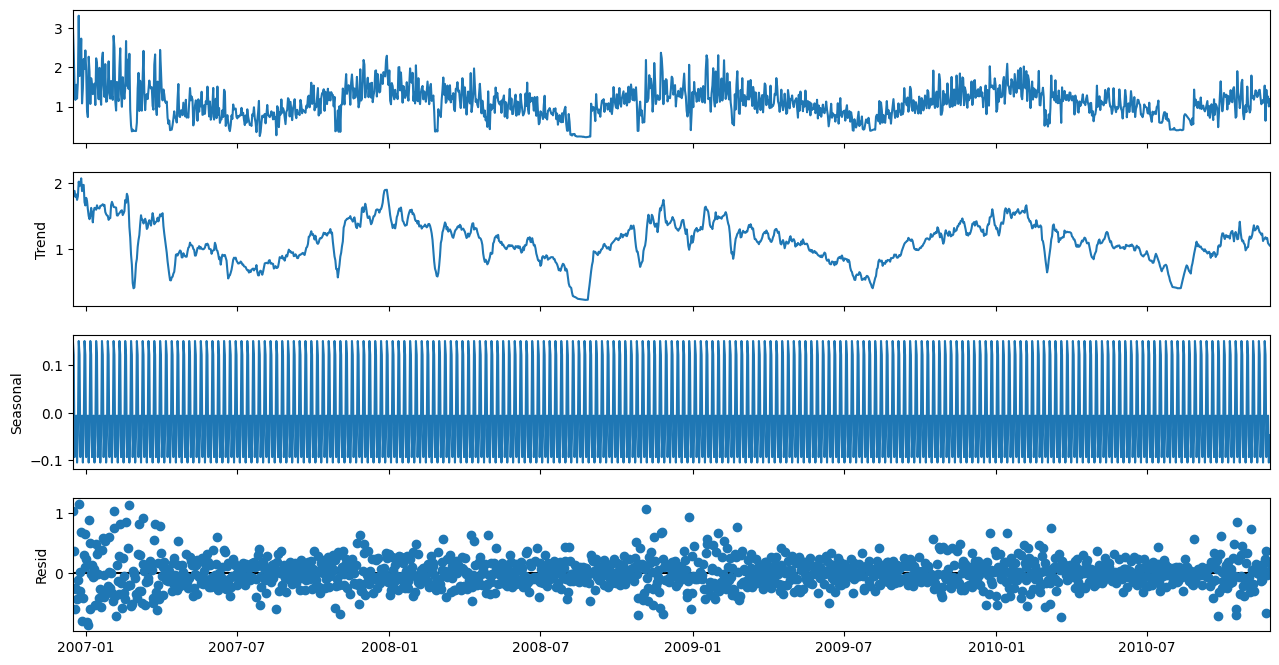

In [10]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', extrapolate_trend=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual
 
trend, seasonal, residual = seasonal_decompose(df_real)

In [11]:
train_data = df_real['Total_power'][:int(len(df_real)*0.8)]
test_data = df_real['Total_power'][int(len(df_real)*0.8):]


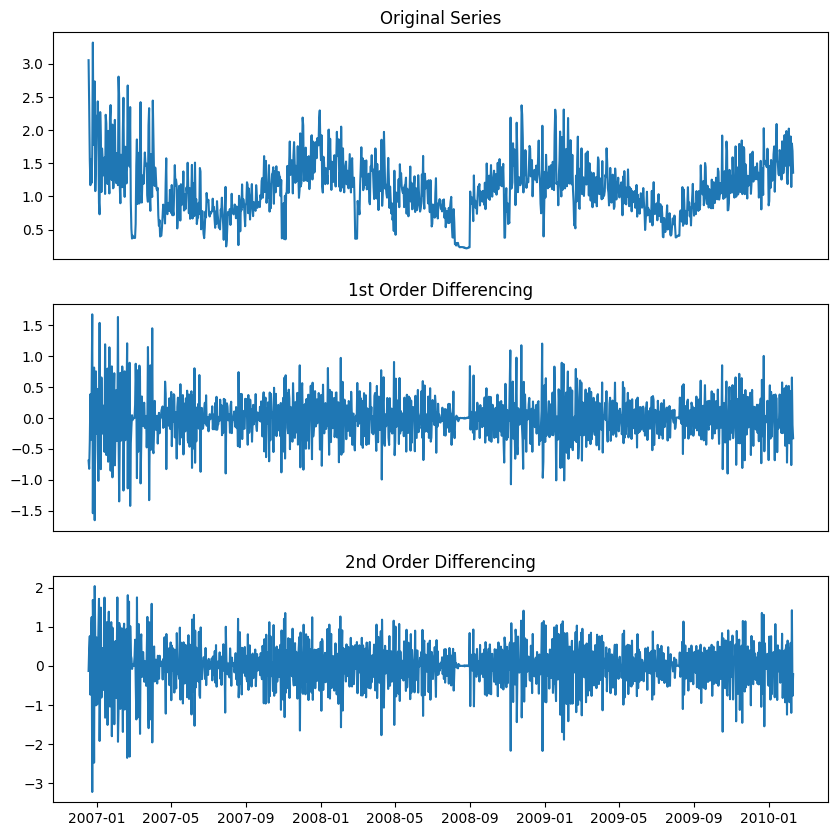

In [12]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 10))
ax1.plot(train_data)
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(train_data.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(train_data.diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()

Text(0.5, 1.0, 'Autocorrelation for second-order differencing')

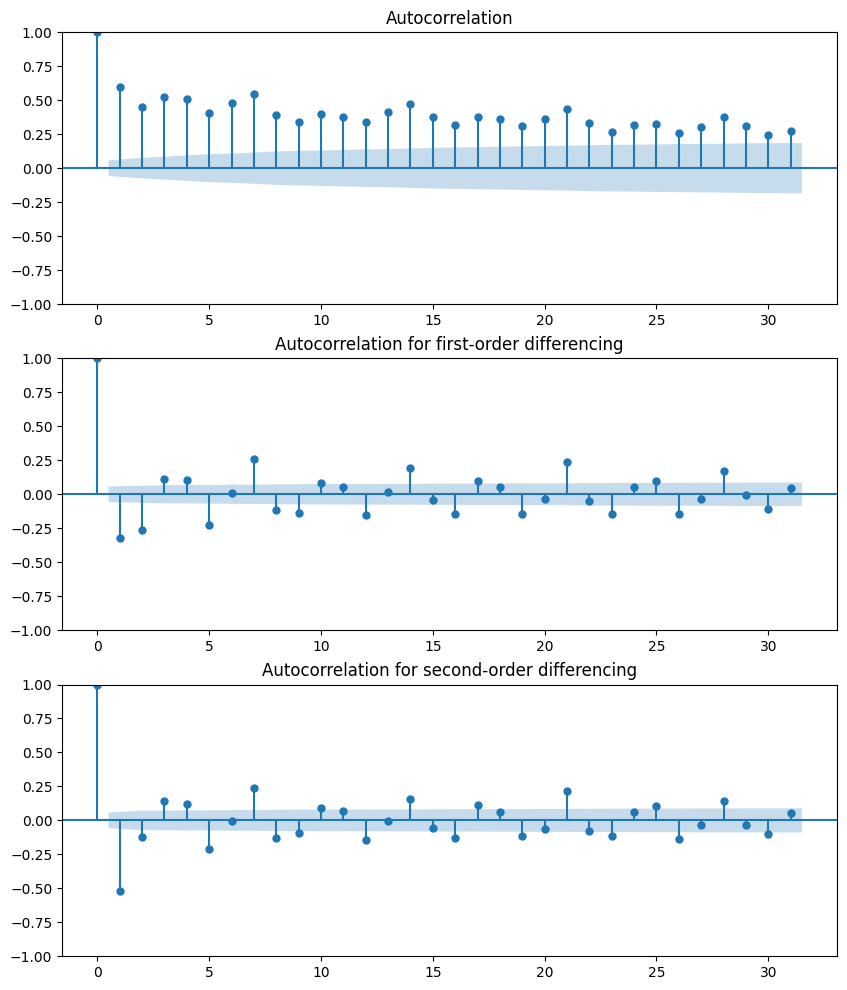

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
_ = plot_acf(train_data, ax=ax1)
_ = plot_acf(train_data.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
_ = plot_acf(train_data.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')

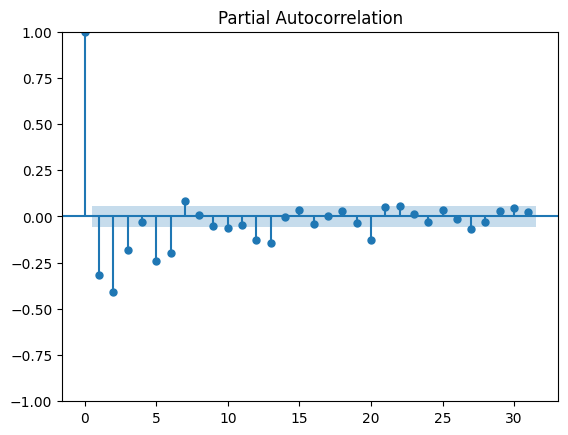

In [16]:
_ = plot_pacf(train_data.diff().dropna())

In [14]:
ARIMA_model = pm.auto_arima(train_data,start_P=0.003966, max_P=5, m=7,seasonal=True)
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1153
Model:             SARIMAX(3, 0, 1)x(3, 0, 1, 7)   Log Likelihood                -228.218
Date:                           Fri, 16 Jun 2023   AIC                            476.436
Time:                                   22:27:26   BIC                            526.937
Sample:                               12-16-2006   HQIC                           495.497
                                    - 02-10-2010                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0045      0.002      2.129      0.033       0.000       0.009
ar.L1          0.9166      0.070     13.148      0.000       0.780       1.053
ar.L2         -0.1614      0.041     -3.889      0.000      -0.243      -0.080
ar.L3          0.1472      0.030      4.902      0.000       0.088       0.206
ma.L1         -0.5554      0.069     -8.085      0.000      -0.690      -0.421
ar.S.L7        0.9309      0.038     24.465      0.000       0.856       1.005
ar.S.L14      -0.0113      0.036     -0.313      0.754      -0.082       0.059
ar.S.L21       0.0432      0.030      1.424      0.154      -0.016       0.103
ma.S.L7       -0.8290      0.031    -26.620      0.000      -0.890      -0.768
sigma2         0.0871      0.003     32.107      0.000       0.082       0.092
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               282.15
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
model = ARIMA(train_data, order=(12, 1, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Total_power   No. Observations:                 1153
Model:                ARIMA(12, 1, 1)   Log Likelihood                -251.833
Date:                Fri, 16 Jun 2023   AIC                            531.667
Time:                        22:28:37   BIC                            602.356
Sample:                    12-16-2006   HQIC                           558.349
                         - 02-10-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0449      0.089     -0.507      0.612      -0.218       0.129
ar.L2         -0.2718      0.057     -4.794      0.000      -0.383      -0.161
ar.L3         -0.0982      0.057     -1.711      0.087      -0.211       0.014
ar.L4         -0.0735      0.042     -1.769      0.077      -0.155       0.008
ar.L5         -0.1923      0.036     -5.412      0.000      -0.262      -0.123
ar.L6         -0.0444      0.042     -1.059      0.290      -0.127       0.038
ar.L7          0.0853      0.033      2.608      0.009       0.021       0.149
ar.L8         -0.1326      0.024     -5.457      0.000      -0.180      -0.085
ar.L9         -0.1372      0.028     -4.915      0.000      -0.192      -0.082
ar.L10        -0.1181      0.028     -4.185      0.000      -0.173      -0.063
ar.L11        -0.1088      0.029     -3.764      0.000      -0.165      -0.052
ar.L12        -0.1341      0.030     -4.414      0.000      -0.194      -0.075
ma.L1         -0.5834      0.089     -6.571      0.000      -0.757      -0.409
sigma2         0.0905      0.003     29.223      0.000       0.084       0.097
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               126.49
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0, 0.5, 'Passengers')

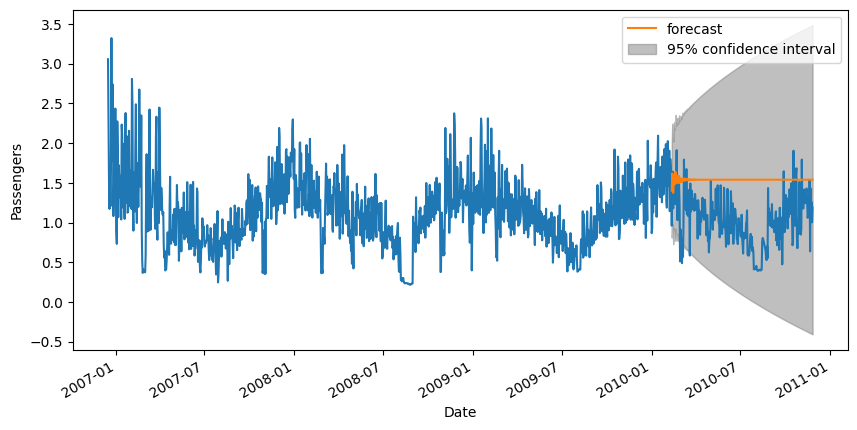

In [16]:

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(df_real)
plot_predict(model_fit, start=len(train_data), end=(len(df_real)-1), ax=axs)
plt.xlabel('Date')
plt.ylabel('Passengers')